## Kết nối đến thư mục driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
project_path = '/content/drive/MyDrive/Project-EdgeAI/Dataset/M9K03_EdgeAI_Part_1'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Project-EdgeAI/Dataset/M9K03_EdgeAI_Part_1


## Accelerometer Dataset (Phát hiện té ngã)

### Load file dữ liệu từng mẫu và lấy thông tin:
### Load file dữ liệu từng mẫu và lấy thông tin:
Thông tin dữ liệu:
+ Số mẫu: 125
+ Thời gian: 10s
+ Tần số lấy mẫu: 16ms = 62.5Hz
+ Định dạng file: JSON

Thông tin:
+ AccX: Tín hiệu gia tốc trên trục X
+ AccX: Tín hiệu gia tốc trên trục Y
+ AccX: Tín hiệu gia tốc trên trục Z
+ Tên file: phân loại Fall/Sitting/Stairs/Standing/Walking

In [ ]:
import glob
import os
import json

dataset_path = 'fall_detection'

data_lst = []
label_lst = []
for data_path in glob.glob(f'{dataset_path}/*/*.json'):
  with open(data_path, 'r') as json_file:
    label = os.path.basename(data_path).split('.')[0]
    data = json.load(json_file)
    acc_lst = data.get('payload', {}).get('values', [])
    if len(acc_lst) > 0:
      data_lst.append(acc_lst)
      label_lst.append(label)

print(f'Số lượng dữ liệu: {len(data_lst)}')
print(f'Số lượng bộ giá trị (x,y,z) trên 1 dữ liệu {len(data_lst[0])}')
print(label_lst[0], data_lst[0])


### Vẽ tín hiệu AccX, AccY, AccZ

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_idx = label_lst.index('Fall')
acc_signal = np.array(data_lst[data_idx])
acc_label = label_lst[data_idx]
time = np.linspace(0, 10, acc_signal.shape[0])

plt.figure(figsize=(12, 4))

# Vẽ tín hiệu AccX
plt.plot(time, acc_signal[:,0], label='AccX', color='red')

# Vẽ tín hiệu AccY
plt.plot(time, acc_signal[:,1], label='AccY', color='blue')

# Vẽ tín hiệu AccZ
plt.plot(time, acc_signal[:,2], label='AccZ', color='green')

# Thêm tiêu đề và nhãn
plt.title(f'Accelerometer Signals - {acc_label}', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Acceleration (m/s²)', fontsize=12)

# Thêm chú thích
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.show()

### Áp dụng cửa sổ trượt (Sliding Windows)
+ Window Size: 500ms
+ Step Size: 100ms

In [ ]:
import numpy as np

def sliding_window_multichannel(data, fs, window_size_ms, step_size_ms):
    """
    Áp dụng cửa sổ trượt cho dữ liệu nhiều kênh.

    Args:
        data (2D array-like): Dữ liệu đầu vào (num_samples, num_channels).
        fs (int): Tần số mẫu (Hz).
        window_size_ms (int): Kích thước cửa sổ (ms).
        step_size_ms (int): Bước nhảy (ms).

    Returns:
        np.array: Mảng 3D (num_windows, window_size, num_channels).
    """
    # Chuyển đổi kích thước cửa sổ và bước nhảy từ ms sang số mẫu
    window_size_samples = int(window_size_ms * fs / 1000)
    step_size_samples = int(step_size_ms * fs / 1000)

    # Kiểm tra kích thước dữ liệu
    num_samples, num_channels = data.shape

    # Tạo danh sách cửa sổ
    windows = [
        data[i : i + window_size_samples]
        for i in range(0, num_samples - window_size_samples + 1, step_size_samples)
    ]

    # Chuyển sang numpy array (num_windows, window_size, num_channels)
    return np.array(windows)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_idx = label_lst.index('Fall')
acc_signal = np.array(data_lst[data_idx])
acc_label = label_lst[data_idx]
time = np.linspace(0, 10, acc_signal.shape[0])

fs = 62.5
window_size_ms = 500
step_size_ms = 100

# acc_signal_normalized = (acc_signal - np.mean(acc_signal)) / np.max(np.abs(acc_signal))

windows = sliding_window_multichannel(acc_signal, fs, window_size_ms, step_size_ms)

print("Dữ liệu ban đầu:", acc_signal.shape)
print("Dữ liệu sau trượt:", windows.shape)

In [ ]:
import matplotlib.pyplot as plt

# Chọn cửa sổ đầu tiên (index 0)
window_0 = windows[50]

# Vẽ từng kênh trong cửa sổ đầu tiên
plt.figure(figsize=(12, 6))

plt.plot(window_0[:, 0], label="AccX (Cửa sổ 0)", color="red")
plt.plot(window_0[:, 1], label="AccY (Cửa sổ 0)", color="blue")
plt.plot(window_0[:, 2], label="AccZ (Cửa sổ 0)", color="green")

plt.title("Tín hiệu trong cửa sổ đầu tiên", fontsize=14)
plt.xlabel("Mẫu trong cửa sổ", fontsize=12)
plt.ylabel("Giá trị tín hiệu", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Bộ lọc thông thấp Butterworth

In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np

def butterworth_lowpass_filter(data, cutoff, fs, order=4):
    """
    Lọc thông thấp bằng bộ lọc Butterworth.

    Args:
        data (ndarray): Dữ liệu đầu vào (1D hoặc 2D: num_samples x num_channels).
        cutoff (float): Tần số cắt (Hz).
        fs (float): Tần số lấy mẫu (Hz).
        order (int): Bậc của bộ lọc (mặc định là 4).

    Returns:
        ndarray: Dữ liệu sau khi được lọc.
    """
    # Tính toán hệ số bộ lọc Butterworth
    nyquist = fs / 2  # Tần số Nyquist
    normal_cutoff = cutoff / nyquist  # Chuẩn hóa tần số cắt
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Kiểm tra dữ liệu đầu vào (1D hoặc nhiều kênh)
    if data.ndim == 1:
        # Lọc dữ liệu 1D
        filtered_data = filtfilt(b, a, data)
    elif data.ndim == 2:
        # Lọc từng kênh trong dữ liệu 2D
        filtered_data = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=0, arr=data)
    else:
        raise ValueError("Dữ liệu đầu vào phải là mảng 1D hoặc 2D.")

    return filtered_data

In [ ]:
filtered_window = butterworth_lowpass_filter(window_0, cutoff=3, fs=fs, order=6)

plt.figure(figsize=(12, 6))
plt.plot(window_0[:, 0], label="Tín hiệu gốc (AccX)", alpha=0.75, color='red')
plt.plot(filtered_window[:, 0], label="Tín hiệu sau lọc (AccX)", linewidth=2, color='red')
plt.plot(window_0[:, 1], label="Tín hiệu gốc (AccY)", alpha=0.75, color='blue')
plt.plot(filtered_window[:, 1], label="Tín hiệu sau lọc (AccY)", linewidth=2, color='blue')
plt.plot(window_0[:, 2], label="Tín hiệu gốc (AccZ)", alpha=0.75, color='green')
plt.plot(filtered_window[:, 2], label="Tín hiệu sau lọc (AccZ)", linewidth=2, color='green')
plt.title("Bộ lọc thông thấp Butterworth", fontsize=14)
plt.xlabel("Thời gian (s)", fontsize=12)
plt.ylabel("Biên độ", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Chuyển đổi tín hiệu Acc sang miền tần số

In [ ]:
def fft_multichannel(data, fs, fft_length=None):
    """
    Thực hiện FFT trên tín hiệu đa kênh.

    Args:
        data (2D array): Tín hiệu đầu vào (num_samples x num_channels).
        fs (float): Tần số lấy mẫu (Hz).

    Returns:
        dict: Bao gồm tần số và phổ năng lượng của mỗi kênh.
    """
    if data.ndim == 1:
        # Nếu dữ liệu là 1D (tín hiệu đơn)
        N = len(data)
        if fft_length is None:
            fft_length = N  # Nếu không chỉ định độ dài FFT, sử dụng độ dài tín hiệu gốc.

        # Đệm dữ liệu nếu cần thiết
        if fft_length > N:
            data = np.pad(data, (0, fft_length - N), mode='constant')
        freqs = np.fft.rfftfreq(fft_length, 1 / fs)  # Tần số sau FFT
        fft_values = np.fft.rfft(data)      # FFT tín hiệu
        power_spectrum = np.abs(fft_values) ** 2  # Spectral power (linear)
        return {"frequencies": freqs, "power_spectrum": power_spectrum}

    elif data.ndim == 2:
        # Nếu dữ liệu là 2D (tín hiệu đa kênh)
        num_samples, num_channels = data.shape
        freqs = np.fft.rfftfreq(fft_length, 1 / fs)
        power_spectrum_multichannel = []

        for channel in range(num_channels):
          if fft_length is None:
                fft_length = num_samples  # Nếu không chỉ định độ dài FFT, sử dụng độ dài tín hiệu gốc

          if fft_length > num_samples:
            data1 = np.pad(data[:, channel], (0, fft_length - num_samples), mode='constant')
          fft_values = np.fft.rfft(data1)  # FFT từng kênh
          power_spectrum = np.abs(fft_values) ** 2  # Spectral power (linear)
          power_spectrum_multichannel.append({
              "frequencies": freqs,
              "power_spectrum": power_spectrum
          })

        return power_spectrum_multichannel
    else:
        raise ValueError("Dữ liệu đầu vào phải là mảng 1D hoặc 2D.")

In [ ]:
fft_results = fft_multichannel(filtered_window, fs, 128)

plt.figure(figsize=(14, 6))
for idx, result in enumerate(fft_results):
  freqs = result["frequencies"]
  power_spectrum = result["power_spectrum"]
  plt.plot(freqs, power_spectrum, label=idx)
plt.title(f"Phổ tín hiệu", fontsize=14)
plt.xlabel("Tần số (Hz)", fontsize=12)
plt.ylabel("Mật độ năng lượng phổ", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Hàm trích xuất 11 đặc trưng cho mỗi trục dựa trên:
+ Tín hiệu trên phổ tần số
+ Tín hiệu trên miền thời gian

In [ ]:
import numpy as np
import scipy.stats as stats

# Hàm tính RMS
def rms(signal):
  return np.sqrt(np.mean(np.square(signal)))

# Hàm tính Skewness
def skewness(signal):
  return stats.skew(signal)

# Hàm tính Kurtosis
def kurtosis(signal):
  return stats.kurtosis(signal)

# Hàm tính Spectral Power trong một dải tần số
def spectral_power(power_spectrum, fmin, fmax):
  # Lọc tần số trong dải [fmin, fmax]
  mask = (freqs >= fmin) & (freqs <= fmax)
  power_in_band = np.sum(power_spectrum[mask])

  return power_in_band

# Hàm tính Spectral Skewness
def spectral_skewness(power_spectrum):
    return stats.skew(power_spectrum)

# Hàm tính Spectral Kurtosis
def spectral_kurtosis(power_spectrum):
    return stats.kurtosis(power_spectrum)


In [ ]:
x_freqs = result["frequencies"]
x_power_spectrum = result["power_spectrum"]
x_time_domain = filtered_window

# Miền thời gian
x_rms = rms(x_time_domain)
x_skewness = skewness(x_time_domain)
x_kurtosis = kurtosis(x_time_domain)

print(f'accX RMS: {x_rms}')
print(f'accX Skewness: {x_skewness}')
print(f'accX Kurtosis: {x_kurtosis}')

# Miền tần số
req_bands = [(0.24, 0.73), (0.73, 1.22), (1.22, 1.71), (1.71, 2.2), (2.2, 2.69), (2.69, 3.17)]
for min_freq, max_freq in req_bands:
  x_spectral_power = spectral_power(x_power_spectrum, min_freq, max_freq)
  print(f'accX Spectral Power {min_freq} - {max_freq} Hz: {x_spectral_power}')

x_spectral_skewness = spectral_skewness(x_power_spectrum)
print(f'accX Spectral Skewness: {x_spectral_skewness}')

x_spectral_kurtosis = spectral_kurtosis(x_power_spectrum)
print(f'accX Spectral Kurtosis: {x_spectral_kurtosis}')

In [ ]:
def spectral_features(window, fs, filter_cut_off, filter_order=3, fft_length=None, is_show=False):
  filtered_window = butterworth_lowpass_filter(window, cutoff=filter_cut_off, fs=fs, order=filter_order)
  fft_results = fft_multichannel(filtered_window, fs, fft_length)
  feature_lst = []
  for idx, acc_name in enumerate(['X', 'Y', 'Z']):
    time_domain = filtered_window[:,idx]

    fft_signal = fft_results[idx]
    freqs = fft_signal["frequencies"]
    power_spectrum = fft_signal["power_spectrum"]

    # Miền thời gian
    rms_ = rms(time_domain)
    skewness_ = skewness(time_domain)
    kurtosis_ = kurtosis(time_domain)
    feature_lst += [rms_, skewness_, kurtosis_]

    if is_show:
      print(f'acc{acc_name} RMS: {rms_}')
      print(f'acc{acc_name} Skewness: {skewness_}')
      print(f'acc{acc_name} Kurtosis: {kurtosis_}')

    # Miền tần số
    req_bands = [(0.24, 0.73), (0.73, 1.22), (1.22, 1.71), (1.71, 2.2), (2.2, 2.69), (2.69, 3.17)]
    for min_freq, max_freq in req_bands:
      spectral_power_ = spectral_power(power_spectrum, min_freq, max_freq)
      if is_show:
        print(f'acc{acc_name} Spectral Power {min_freq} - {max_freq} Hz: {spectral_power_}')
      feature_lst.append(spectral_power_)

    spectral_skewness_ = spectral_skewness(power_spectrum)
    feature_lst.append(spectral_skewness_)

    if is_show:
      print(f'acc{acc_name} Spectral Skewness: {spectral_skewness_}')

    spectral_kurtosis_ = spectral_kurtosis(power_spectrum)
    feature_lst.append(spectral_kurtosis_)
    if is_show:
      print(f'acc{acc_name} Spectral Kurtosis: {spectral_kurtosis_}')
  return feature_lst

feature = spectral_features(window_0, fs, filter_cut_off=3, filter_order=6, fft_length=128)
print(len(feature))
print(feature)

### Trích xuất đặc trưng toàn bộ data

In [ ]:
fs = 62.5
window_size_ms = 500
step_size_ms = 100

feature_lst = []

if os.path.exists(r'fall_detection/features.txt'):
  os.remove(r'fall_detection/features.txt')

for idx, data in enumerate(data_lst):
  windows = sliding_window_multichannel(acc_signal, fs, window_size_ms, step_size_ms)
  for signal_window in windows:
    feature = spectral_features(signal_window, fs, filter_cut_off=3, filter_order=6, fft_length=128)
    with open(r'fall_detection/features.txt', 'a') as feature_file:
      feature_file.write(' '.join([str(ele) for ele in ([label_lst[idx]] + feature)]) + '\n')

## HeartRate Dataset (Ước tính Heart Rate)

### Load file dữ liệu từng mẫu và lấy thông tin:
Thông tin dữ liệu:
+ Số mẫu: 92
+ Thời gian: 100s
+ Tần số lấy mẫu: 32Hz
+ Định dạng file: CSV

Thông tin:
+ Thời gian: xác định tần số lấy mẫu
+ PPG (Photoplethysmogram): đo các thay đổi thể tích máu trong mạch máu dưới da theo phương pháp quang học. => dữ liệu đầu vào
+ HR (Heart Rate): nhịp tim, được tính trung bình số lần tim đập trong 1 phút. => dữ liệu đầu ra (nhãn)

In [ ]:
dataset_path = 'HeartRate'
import os
import glob
import pandas as pd

data_lst = []
for data_path in glob.glob(f'{dataset_path}/*.csv'):
  df = pd.read_csv(data_path, index_col=False)[['Time', 'ppg', 'hr']]
  data_lst.append(df)

print(len(data_lst), data_lst[0].shape)
data_lst[0]

94 (3200, 3)


,Time,ppg,hr
0,2018-06-29 09:31:32.000000,-83.28,84.98
1,2018-06-29 09:31:32.031250,-67.62,84.98
2,2018-06-29 09:31:32.062500,-38.87,84.98
3,2018-06-29 09:31:32.093750,2.46,84.98
4,2018-06-29 09:31:32.125000,48.62,84.98
...,...,...,...
3195,2018-06-29 09:33:11.843750,-7.12,104.77
3196,2018-06-29 09:33:11.875000,10.37,104.77
3197,2018-06-29 09:33:11.906250,1.59,104.77
3198,2018-06-29 09:33:11.937500,-18.86,104.77


### Vẽ tín hiệu PPG, HR

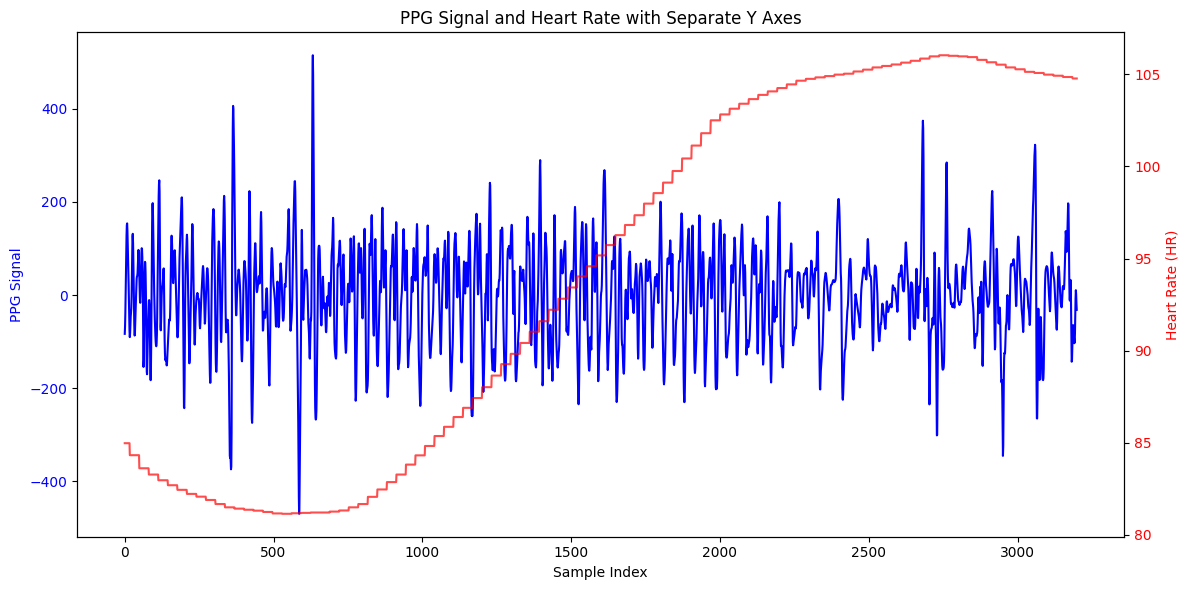

In [ ]:
import matplotlib.pyplot as plt

data_idx = 0
ppg_signal = data_lst[data_idx]['ppg']
hr_signal = data_lst[data_idx]['hr']
# Vẽ tín hiệu PPG
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y cho PPG
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('PPG Signal', color='blue')
ax1.plot(ppg_signal, color='blue', label='PPG Signal')
ax1.tick_params(axis='y', labelcolor='blue')

# Trục y cho HR
ax2 = ax1.twinx()  # Tạo trục y thứ hai
ax2.set_ylabel('Heart Rate (HR)', color='red')
ax2.plot(hr_signal, color='red', label='Heart Rate (HR)', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='red')

# Thêm tiêu đề và hiển thị biểu đồ
plt.title('PPG Signal and Heart Rate with Separate Y Axes')
fig.tight_layout()  # Đảm bảo không bị chồng chéo các thành phần
plt.show()

### Tìm đỉnh các tín hiệu

<ipython-input-6-6d34b97e45c2>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(peaks, ppg_signal.iloc[peaks], 'ro', label='Peaks', color='green')


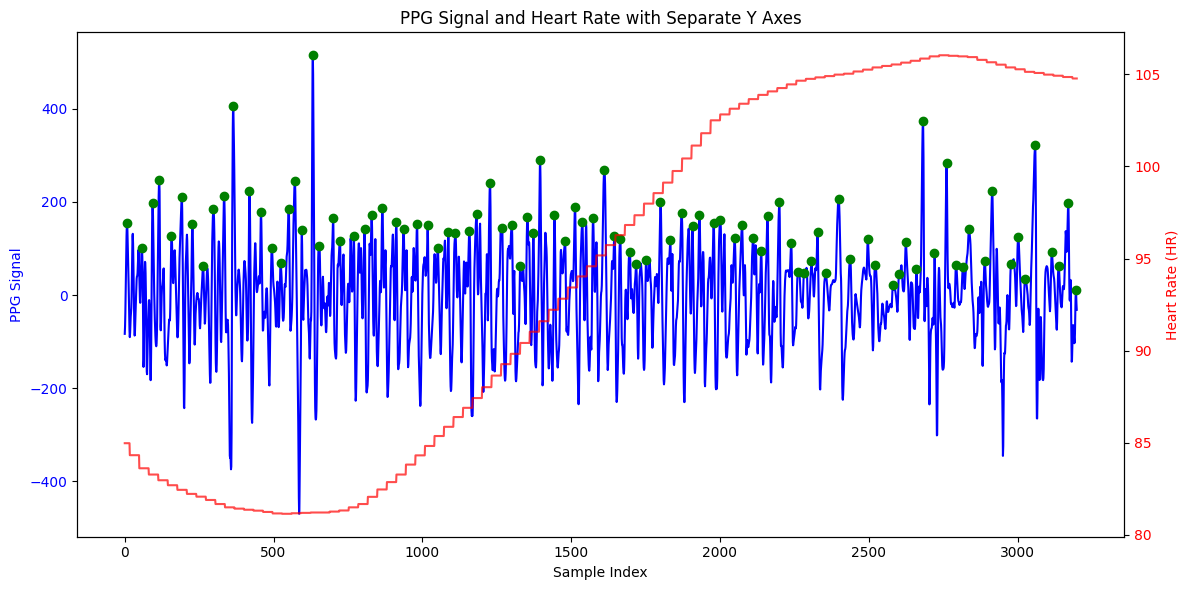

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

sampling_rate = 32

data_idx = 0
ppg_signal = data_lst[data_idx]['ppg']
hr_signal = data_lst[data_idx]['hr']

# Tìm đỉnh
peaks, _ = find_peaks(ppg_signal, height=np.mean(ppg_signal), distance=sampling_rate * 0.6)

# Vẽ tín hiệu PPG
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y cho PPG
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('PPG Signal', color='blue')
ax1.plot(ppg_signal, color='blue', label='PPG Signal')
ax1.tick_params(axis='y', labelcolor='blue')


# Đánh dấu đỉnh
plt.plot(peaks, ppg_signal.iloc[peaks], 'ro', label='Peaks', color='green')

# Trục y cho HR
ax2 = ax1.twinx()  # Tạo trục y thứ hai
ax2.set_ylabel('Heart Rate (HR)', color='red')
ax2.plot(hr_signal, color='red', label='Heart Rate (HR)', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='red')

# Thêm tiêu đề và hiển thị biểu đồ
plt.title('PPG Signal and Heart Rate with Separate Y Axes')
fig.tight_layout()  # Đảm bảo không bị chồng chéo các thành phần
plt.show()

### Tìm HeartRate dựa trên khoảng cách giữa các đỉnh

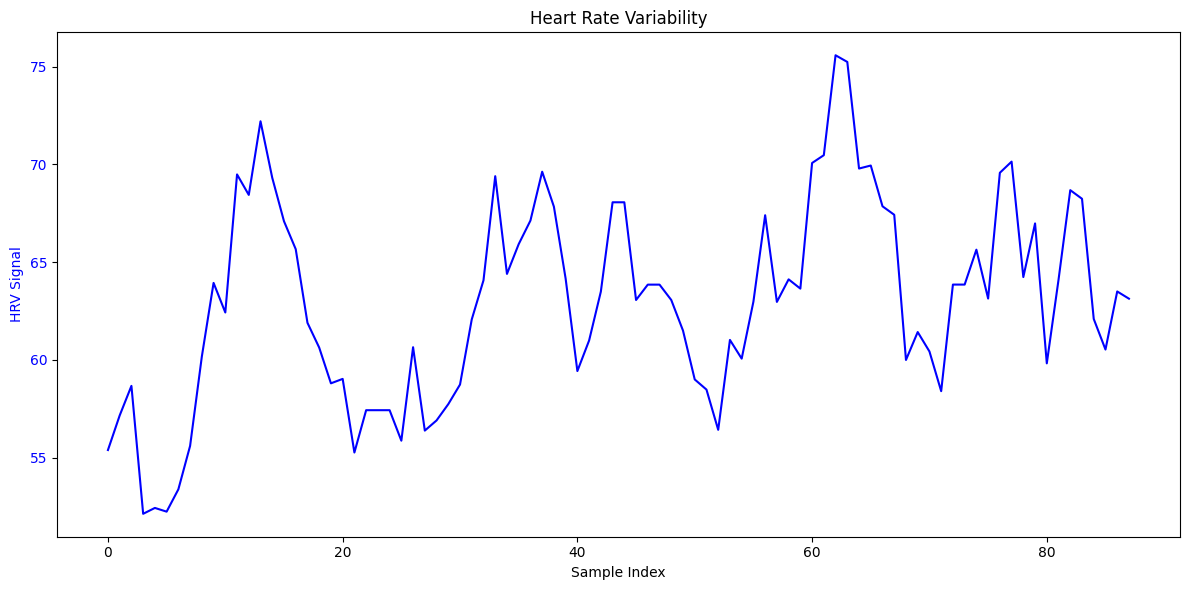

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

data_idx = 0
ppg_signal = data_lst[data_idx]['ppg']

# Tìm đỉnh
peaks, _ = find_peaks(ppg_signal, height=np.mean(ppg_signal), distance=sampling_rate * 0.6)
rr_intervals = np.diff(peaks) / sampling_rate
hrv = 60 / rr_intervals

window_size = 8  # Cửa sổ trượt 8 giây
hrv_smoothed = np.convolve(hrv, np.ones(window_size)/window_size, mode='valid')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y cho PPG
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('HRV Signal', color='blue')
ax1.plot(hrv_smoothed, color='blue', label='HRV Signal')
ax1.tick_params(axis='y', labelcolor='blue')

# Thêm tiêu đề và hiển thị biểu đồ
plt.title('Heart Rate Variability')
fig.tight_layout()  # Đảm bảo không bị chồng chéo các thành phần
plt.show()

### Chuyển đổi tín hiệu PPG sang miền tần số

In [1]:
from scipy.fft import fft
import matplotlib.pyplot as plt

data_idx = 0
ppg_signal = data_lst[data_idx]['ppg'].values
signal_normalized = (ppg_signal - np.mean(ppg_signal)) / np.max(np.abs(ppg_signal))
N = len(signal_normalized)
fft_result = np.fft.fft(signal_normalized)
frequencies = np.fft.fftfreq(N, 1/sampling_rate)
positive_frequencies = frequencies[:N//2]
positive_fft_result = fft_result[:N//2]

plt.figure(figsize=(20, 6))
plt.plot(positive_frequencies, np.abs(positive_fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of PPG Signal')

NameError: name 'data_lst' is not defined

### Hàm trích xuất 29 đặc trưng thống kê dựa trên 3 tín hiệu đã được biến đổi:
+ Interbeat intervals (IBIs): khoảng thời gian giữa hai nhịp tim liên tiếp.
+ Heart Rate Variability time-domain features (HRV): tốc độ nhịp tim biến thiên trên miền thời gian
+ PPG frequency-domain features: tín hiệu PPG trên miền tần số

In [ ]:
def calculate_hr_and_hrv(data, sampling_rate=32, is_show=True):
  # Tìm vị trí các đỉnh PPG
  peaks, _ = find_peaks(ppg_signal, height=np.mean(ppg_signal), distance=sampling_rate * 0.6)

  # Tìm IBI (khoảng thời gian giữa hai nhịp tim liên tiếp)
  IBI = (np.diff(peaks)/sampling_rate)*1000

  ## Interbeat intervals (IBIs)
  # IBI Slope (độ dốc của biểu đồ IBI qua thời gian, đo lường sự thay đổi tốc độ tim.)
  x = np.arange(len(IBI))
  IBI_Slope, intercept, r_value, p_value, std_err = linregress(x, IBI)
  if is_show:
    print(f'IBI Slope: {IBI_Slope}')

  ## Heart Rate Variability time-domain features (HRV)
  # Tính nhịp tim biến thiên trung bình (HRV Mean) (Tốc độ tim trung bình có thể tính bằng cách lấy giá trị trung bình của tất cả các giá trị nhịp tim.)
  window_size = 8
  hrv = (60 / IBI) * 1000
  hrv_smoothed = np.convolve(hrv, np.ones(window_size)/window_size, mode='valid')
  hrv_mean = np.mean(hrv_smoothed)
  if is_show:
    print(f'HRV Mean: {hrv_mean}')

  # HRV Slope (Tính độ dốc của tốc độ tim biến thiên theo thời gian.)
  hrv_slope, _, _, _, _ = linregress(np.arange(len(hrv_smoothed)), hrv_smoothed)
  if is_show:
    print(f'HRV Slope: {hrv_slope}')

  # RMSSD (Root Mean Square of Successive Differences) (đo sự biến thiên trong các khoảng thời gian nhịp tim liên tiếp)
  rmssd = np.sqrt(np.mean(np.diff(IBI)**2))
  if is_show:
    print(f'RMSSD: {rmssd}')

  # AVNN (trung bình của các khoảng cách NN (Normal to Normal intervals, tức là các khoảng cách giữa các nhịp tim bình thường))
  avnn = np.mean(IBI)
  if is_show:
    print(f'AVNN: {avnn}')

  # SDNN (Standard Deviation of NN intervals) (độ lệch chuẩn của các khoảng NN, đo lường sự thay đổi nhịp tim tổng thể)
  sdnn = np.std(IBI)
  if is_show:
    print(f'SDNN: {sdnn}')

  # Range NN (hiệu giữa giá trị lớn nhất và nhỏ nhất trong các khoảng NN)\
  range_nn = np.max(IBI) - np.min(IBI)
  if is_show:
    print(f'Range NN: {range_nn}')

  # MAD NN (Mean Absolute Deviation) (độ lệch tuyệt đối trung bình giữa các khoảng NN)
  mad_nn = np.mean(np.abs(IBI - np.mean(IBI)))
  if is_show:
    print(f'MAD NN: {mad_nn}')

  # pNN50 (Proportion of NN intervals > 50) (tỷ lệ phần trăm của các khoảng NN có sự thay đổi > 50)
  pnn50 = np.sum(IBI > 50) / len(IBI) * 100
  if is_show:
    print(f'pNN50: {pnn50}')

  # NN Percentile (10, 25, 75, 90) (phân vị của các khoảng NN, cho biết phân bố các giá trị NN)
  percentile_10 = np.percentile(IBI, 10)
  percentile_25 = np.percentile(IBI, 25)
  percentile_75 = np.percentile(IBI, 75)
  percentile_90 = np.percentile(IBI, 90)
  if is_show:
    print(f'NN Percentile 10: {percentile_10}')
    print(f'NN Percentile 25: {percentile_25}')
    print(f'NN Percentile 75: {percentile_75}')
    print(f'NN Percentile 90: {percentile_90}')

  # IQR (Interquartile Range) (hiệu giữa phân vị 75 và phân vị 25 của các khoảng NN)
  iqr = percentile_75 - percentile_25
  if is_show:
    print(f'IQR: {iqr}')

  # SDSD (Standard Deviation of Successive Differences) (độ lệch chuẩn của sự khác biệt giữa các khoảng NN liên tiếp)
  sdsd = np.std(np.diff(IBI))
  if is_show:
    print(f'SDSD: {sdsd}')

  # SD1 và SD2 (Poincaré Plot) (các chỉ số đo sự biến thiên của tín hiệu nhịp tim trong mô hình Poincaré plot)
  sd1 = np.std(IBI) / np.sqrt(2)
  sd2 = np.std(np.diff(IBI)) / np.sqrt(2)
  if is_show:
    print(f'SD1: {sd1}')
    print(f'SD2: {sd2}')

  # SD2/SD1 Ratio (tỷ lệ giữa độ lệch chuẩn của các khác biệt liên tiếp (SD2) và độ lệch chuẩn của các khác biệt nối tiếp (SD1))
  sd2_sd1_ratio = sd2 / sd1
  if is_show:
    print(f'SD2/SD1 Ratio: {sd2_sd1_ratio}')

  ## PPG frequency-domain features
  # Chuyển sang miền Tần số
  from scipy.fft import fft
  signal_normalized = (ppg_signal - np.mean(ppg_signal)) / np.max(np.abs(ppg_signal))
  N = len(signal_normalized)
  fft_result = np.fft.fft(signal_normalized)
  frequencies = np.fft.fftfreq(N, 1/sampling_rate)
  positive_frequencies = frequencies[:N//2]
  positive_fft_result = fft_result[:N//2]

  # Raw VLF Energy (Very Low Frequency) (thành phần tần số rất thấp trong tín hiệu. Nó có thể được tính bằng phương pháp phân tích phổ, như FFT)
  mask = (positive_frequencies >= 0) & (positive_frequencies <= 0.04)
  vlf_energy = np.sum(np.abs(positive_fft_result)[mask]) # (0-0.04 Hz)
  if is_show:
    print(f'Raw VLF Energy: {vlf_energy}')

  # Raw LF Energy (Low Frequency) (thành phần tần số thấp (0.04 - 0.15 Hz))
  mask = (positive_frequencies > 0.04) & (positive_frequencies <= 0.15)
  lf_energy = np.sum(np.abs(positive_fft_result)[mask]) # (0.04 - 0.15 Hz)
  if is_show:
    print(f'Raw LF Energy: {lf_energy}')

  # Raw HF Energy (High Frequency)
  mask = (positive_frequencies > 0.15) & (positive_frequencies <= 0.4)
  hf_energy = np.sum(np.abs(positive_fft_result)[mask]) # (0.15 - 0.4 Hz)
  if is_show:
    print(f'Raw HF Energy: {hf_energy}')

  # Raw Total Energy (tổng năng lượng của tất cả các thành phần tần số)
  total_energy = np.sum(np.abs(positive_fft_result)**2)
  if is_show:
    print(f'Raw Total Energy: {total_energy}')

  # Relative VLF Energy (Năng lượng VLF tương đối so với tổng năng lượng)
  relative_vlf_energy = vlf_energy / total_energy
  if is_show:
    print(f'Relative VLF Energy: {relative_vlf_energy}')

  # Relative LF Energy (Năng lượng LF tương đối)
  relative_lf_energy = lf_energy / total_energy
  if is_show:
    print(f'Relative LF Energy: {relative_lf_energy}')

  # Relative HF Energy (Năng lượng HF tương đối)
  relative_hf_energy = hf_energy / total_energy
  if is_show:
    print(f'Relative HF Energy: {relative_hf_energy}')

  # LF/HF Ratio (Tỷ lệ LF/HF dùng để đánh giá cân bằng giữa các thành phần tần số thấp và cao)
  lf_hf_ratio = lf_energy / hf_energy
  if is_show:
    print(f'LF/HF Ratio: {lf_hf_ratio}')

  # Peak VLF Energy (Đỉnh LF có thể tính bằng cách tìm giá trị cực đại trong dải tần số LF)
  mask = (positive_frequencies >= 0) & (positive_frequencies <= 0.04)
  peak_vlf_energy = np.max(np.abs(positive_fft_result)[mask])
  if is_show:
    print(f'Peak VLF Energy: {peak_vlf_energy}')

  # Peak LF Energy (Đỉnh LF có thể tính bằng cách tìm giá trị cực đại trong dải tần số LF)
  mask = (positive_frequencies > 0.04) & (positive_frequencies <= 0.15)
  peak_lf_energy = np.max(np.abs(positive_fft_result)[mask])
  if is_show:
    print(f'Peak LF Energy: {peak_lf_energy}')

  # Peak HF Energy (Đỉnh HF có thể tính bằng cách tìm giá trị cực đại trong dải tần số HF)
  mask = (positive_frequencies > 0.15) & (positive_frequencies <= 0.4)
  peak_hf_energy = np.max(np.abs(positive_fft_result)[mask])
  if is_show:
    print(f'Peak HF Energy: {peak_hf_energy}')
  return [IBI_Slope, hrv_mean, hrv_slope, rmssd, avnn, sdnn, range_nn, mad_nn, pnn50,
  percentile_10, percentile_25, percentile_75, percentile_90, iqr, sdsd, sd1, sd2, sd2_sd1_ratio,
  vlf_energy, lf_energy, hf_energy, total_energy, relative_vlf_energy, relative_lf_energy,
  relative_hf_energy, lf_hf_ratio, peak_vlf_energy, peak_lf_energy, peak_hf_energy]

In [ ]:
from scipy.stats import linregress

sampling_rate = 32
data_idx = 1
ppg_signal = data_lst[data_idx]['ppg']

feature_lst = calculate_hr_and_hrv(ppg_signal, sampling_rate)
print(feature_lst + [data_lst[data_idx]['hr'].values[-1]])


IBI Slope: -1.3658626101042823
HRV Mean: 52.86107462639493
HRV Slope: 0.10801833711496792
RMSSD: 331.67808778341487
AVNN: 1188.6160714285713
SDNN: 234.42194116093648
Range NN: 1031.25
MAD NN: 190.7684948979592
pNN50: 100.0
NN Percentile 10: 875.0
NN Percentile 25: 1031.25
NN Percentile 75: 1343.75
NN Percentile 90: 1459.375
IQR: 312.5
SDSD: 331.6473140829767
SD1: 165.761344253812
SD2: 234.5100647503776
SD2/SD1 Ratio: 1.4147451916853322
Raw VLF Energy: 4.3011580178106446
Raw LF Energy: 60.57618257316467
Raw HF Energy: 307.23519716759756
Raw Total Energy: 77418.25836999982
Relative VLF Energy: 5.555741124082658e-05
Relative LF Energy: 0.0007824534399063466
Relative HF Energy: 0.0039685108349925575
LF/HF Ratio: 0.19716550425086946
Peak VLF Energy: 1.6918940233309225
Peak LF Energy: 9.651206103786743
Peak HF Energy: 30.893964541797423
[-1.3658626101042823, 52.86107462639493, 0.10801833711496792, 331.67808778341487, 1188.6160714285713, 234.42194116093648, 1031.25, 190.7684948979592, 100.0, 

### Trích xuất đặc trưng toàn bộ data

In [ ]:
sampling_rate = 32

feature_lst = []
for data in data_lst:
  ppg_signal = data['ppg'].values
  hr_signal = data['hr'].values
  feature_lst.append([hr_signal[-1]] + calculate_hr_and_hrv(ppg_signal, sampling_rate, is_show=False))

print(feature_lst)
print(len(feature_lst), len(feature_lst[0]))

[[104.77, -0.6500209966405379, 62.954309612507046, 0.08215470103504886, 515.11600441582, 1048.6842105263158, 328.58960808304056, 1375.0, 268.5664819944599, 100.0, 687.5, 750.0, 1218.75, 1500.0, 468.75, 515.0592514066129, 232.34794010294794, 364.2018893824828, 1.5674849074242425, 13.300561463103541, 81.45831710152, 477.87882003956554, 206631.48090630837, 6.436851444303558e-05, 0.0003942202647158839, 0.0023127106186508297, 0.17045810294495942, 3.6813961938446353, 16.88959150451873, 37.331904020006675], [72.03, -1.3658626101042823, 52.86107462639493, 0.10801833711496792, 331.67808778341487, 1188.6160714285713, 234.42194116093648, 1031.25, 190.7684948979592, 100.0, 875.0, 1031.25, 1343.75, 1459.375, 312.5, 331.6473140829767, 165.761344253812, 234.5100647503776, 1.4147451916853322, 4.3011580178106446, 60.57618257316467, 307.23519716759756, 77418.25836999982, 5.555741124082658e-05, 0.0007824534399063466, 0.0039685108349925575, 0.19716550425086946, 1.6918940233309225, 9.651206103786743, 30.89

### Lưu toàn bộ mẫu trích xuất xuống file .txt để phục vụ cho quá trình huấn luyện

In [ ]:
with open(r'HeartRate/features.txt', 'w') as feature_file:
  feature_file.write('\n'.join([' '.join([str(ele) for ele in feature]) for feature in feature_lst]))